# Mbpp Dataset

https://github.com/google-research/google-research/tree/master/mbpp

In [1]:
import json
import numpy as np
import torch
from transformers import AutoTokenizer

import os 
import sys

sys.path.append(os.path.join(os.getcwd(), "../../"))

import src.visualization.plot_rawdata as plotutils

In [2]:
# DATASET_PATH = "../raw_instruct/sanitized-mbpp.json"
DATASET_PATH = "../raw_instruct/mbpp.jsonl"

# Open the JSON file
with open(DATASET_PATH, 'r') as file: 
    if "jsonl" in DATASET_PATH: 
        data = [json.loads(line) for line in file]
    else:
        data = json.load(file)

In [3]:
print(f"Type of data: {type(data)}\nNumber of entries: {len(data)}")

Type of data: <class 'list'>
Number of entries: 974


In [4]:
# from datasets import load_dataset
# dataset_sanitized = load_dataset("mbpp", "sanitized")
# sum([len(dataset_sanitized[elem]) for elem in dataset_sanitized.keys()])

In [5]:
idx = 1

In [6]:
type(data[idx])

dict

In [7]:
data[idx]

{'text': 'Write a function to find the similar elements from the given two tuple lists.',
 'code': 'def similar_elements(test_tup1, test_tup2):\r\n  res = tuple(set(test_tup1) & set(test_tup2))\r\n  return (res) ',
 'task_id': 2,
 'test_setup_code': '',
 'test_list': ['assert similar_elements((3, 4, 5, 6),(5, 7, 4, 10)) == (4, 5)',
  'assert similar_elements((1, 2, 3, 4),(5, 4, 3, 7)) == (3, 4)',
  'assert similar_elements((11, 12, 14, 13),(17, 15, 14, 13)) == (13, 14)'],
 'challenge_test_list': []}

In [8]:
data[idx].keys()

dict_keys(['text', 'code', 'task_id', 'test_setup_code', 'test_list', 'challenge_test_list'])

In [9]:
data[idx]['test_list']

['assert similar_elements((3, 4, 5, 6),(5, 7, 4, 10)) == (4, 5)',
 'assert similar_elements((1, 2, 3, 4),(5, 4, 3, 7)) == (3, 4)',
 'assert similar_elements((11, 12, 14, 13),(17, 15, 14, 13)) == (13, 14)']

#### Check if all elements in data are of type dict and if just one input prompt per data sample (no conversation)

In [10]:
verbose= False

if "jsonl" in DATASET_PATH:
    keys = ['text', 'code', 'task_id', 'test_setup_code', 'test_list', 'challenge_test_list']
else:
    keys = ['source_file', 'task_id', 'prompt', 'code', 'test_imports', 'test_list']

for i, elem in enumerate(data):
    if not isinstance(elem, dict):
        print(f"Elem is not a dict! {elem}")
    elif sorted(list(elem.keys())) != sorted(keys):
        print(f"Elem has different keys in dict! {elem.keys()}\n{elem}\n")
    if verbose and len(elem['test_imports']):
        print(f"Test imports from sample {i}:\n{elem['test_imports']}")

### No data

In [11]:
no_conver_data = []

if "jsonl" in DATASET_PATH:
    prompt_key = "text"
else:
    prompt_key = "prompt"

for elem in data: 
    if not elem[prompt_key]:
        no_conver_data.append(elem)
print(f"There are {len(no_conver_data)} elements in the dataset with no prompts!")

There are 0 elements in the dataset with no prompts!


So all of the elements in this dataset have an instruction!

#### Plot conversations lengths (number of tokens of first human input)

In [12]:
access_tk = os.getenv("HF_API_TOKEN")
device_str = "cuda:0"
model_name = "meta-llama/Llama-3.2-3B-Instruct"
padding_side='left'

tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_tk, device_map=device_str, torch_dtype=torch.float16, padding_side=padding_side)



#### Input handling
Each sample in the dataset is of type `dict`.
The keys of that `dict` are `['source_file', 'task_id', 'prompt', 'code', 'test_imports', 'test_list']`. However, the tokenizers do not recognize those keyas, so we need to append it to the user's `content`.  

In [13]:
def get_tokens(sentence, tokenizer):
    return tokenizer.apply_chat_template(sentence, return_tensors="pt", add_generation_prompt=True)   

In [14]:
from src.data.rawdata_processor import mbpp_generate_rawprompt_text

In [15]:
mystring = mbpp_generate_rawprompt_text(data[idx], tokenizer, truncate=False, prompt_key=prompt_key)
print(mystring)

You are an expert Python programmer, and here is your task: Write a function to find the similar elements from the given two tuple lists. Your code should pass these tests:

assert similar_elements((3, 4, 5, 6),(5, 7, 4, 10)) == (4, 5)
assert similar_elements((1, 2, 3, 4),(5, 4, 3, 7)) == (3, 4)
assert similar_elements((11, 12, 14, 13),(17, 15, 14, 13)) == (13, 14)



In [16]:
from src.data.rawdata_processor import build_rawprompt_text_chat, build_rawprompt_text_batch

In [17]:
build_rawprompt_text_chat(mystring)

[{'role': 'user',
  'content': 'You are an expert Python programmer, and here is your task: Write a function to find the similar elements from the given two tuple lists. Your code should pass these tests:\n\nassert similar_elements((3, 4, 5, 6),(5, 7, 4, 10)) == (4, 5)\nassert similar_elements((1, 2, 3, 4),(5, 4, 3, 7)) == (3, 4)\nassert similar_elements((11, 12, 14, 13),(17, 15, 14, 13)) == (13, 14)\n'}]

In [18]:
get_tokens(build_rawprompt_text_chat(mystring), tokenizer)

tensor([[128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,   2696,
             25,   6790,    220,   2366,     18,    198,  15724,   2696,     25,
            220,    605,   3297,    220,   2366,     20,    271, 128009, 128006,
            882, 128007,    271,   2675,    527,    459,   6335,  13325,  48888,
             11,    323,   1618,    374,    701,   3465,     25,   9842,    264,
            734,    311,   1505,    279,   4528,   5540,    505,    279,   2728,
           1403,  14743,  11725,     13,   4718,   2082,   1288,   1522,   1521,
           7177,   1473,   2256,   4528,  23646,   1209,     18,     11,    220,
             19,     11,    220,     20,     11,    220,     21,  24457,     20,
             11,    220,     22,     11,    220,     19,     11,    220,    605,
            595,    624,    320,     19,     11,    220,     20,    340,   2256,
           4528,  23646,   1209,     16,     11,    220,     17,     11,    220,
             18,     11,    

In [19]:
print(tokenizer.decode(get_tokens(build_rawprompt_text_batch(mystring, 5), tokenizer)[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 10 May 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

You are an expert Python programmer, and here is your task: Write a function to find the similar elements from the given two tuple lists. Your code should pass these tests:

assert similar_elements((3, 4, 5, 6),(5, 7, 4, 10)) == (4, 5)
assert similar_elements((1, 2, 3, 4),(5, 4, 3, 7)) == (3, 4)
assert similar_elements((11, 12, 14, 13),(17, 15, 14, 13)) == (13, 14)<|eot_id|><|start_header_id|>assistant<|end_header_id|>




### Analyze lenght of prompts in terms of number of tokens

In [20]:
tmp_model_input = [build_rawprompt_text_chat(mbpp_generate_rawprompt_text(elem, tokenizer, truncate=False, prompt_key=prompt_key)) for elem in data]

In [21]:
len(tmp_model_input)

974

In [22]:
conv_len_tokens = [get_tokens(elem, tokenizer).shape[1] for elem in tmp_model_input]

In [23]:
len(conv_len_tokens)

974

In [24]:
np.max(conv_len_tokens)

np.int64(2265)

In [ ]:
print(f"MEAN: {np.mean(conv_len_tokens)}\nMIN: {np.min(conv_len_tokens)},\nMAX: {np.max(conv_len_tokens)}")
print(*[f"P{p}: {v:.2f}" for p, v in zip([25, 50, 75, 99], np.percentile(conv_len_tokens, [25, 50, 75, 99]))])

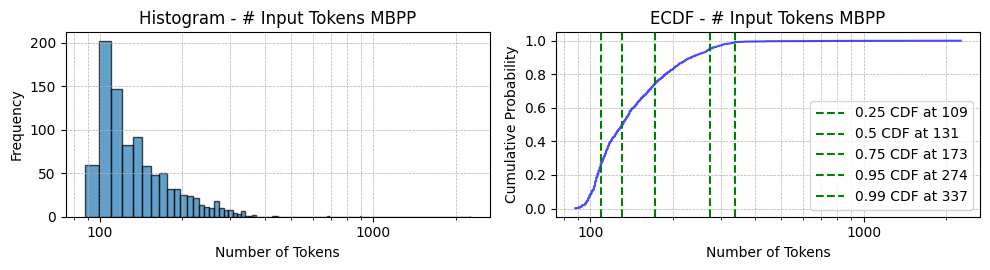

In [25]:
fig = plotutils.plot_histogram_and_cdf(conv_len_tokens, in_size=(10, 2.8), 
                                       in_title="# Input Tokens MBPP", n_bins=200, 
                                       x_forcdf=0, cdf_forx=[0.25, 0.5, 0.75, 0.95, 0.99], logx=True)

# fig = plotutils.plot_histogram_and_cdf(conv_len_tokens, in_size=(10, 2.8), 
#                              in_title="# Input Tokens MBPP", x_forcdf=0, 
#                                        cdf_forx=[0.25, 0.5, 0.75, 0.95, 0.999],
#                                       n_bins=80)

In [26]:
fig.savefig("../../outputs/images/raw_data_MBPP_ntokens_hist.pdf", bbox_inches="tight")

# Split the datasets

In [27]:
SEED = 42
MAXIMUM = 2000

In [28]:
np.random.seed(SEED)

In [29]:
tmp = np.arange(len(data))
np.random.shuffle(tmp)

In [30]:
idx_subset = min(MAXIMUM, len(data))
tmp = tmp[0:idx_subset]
print(f"SELECTING {len(tmp)} samples randomly from dataset")

SELECTING 974 samples randomly from dataset


In [31]:
train_indxs, val_indxs, test_indxs = np.split(tmp, [int(0.7*len(tmp)), int(0.9*len(tmp))])

In [32]:
print(f"Selecting {len(train_indxs)} training, {len(val_indxs)} validation, and {len(test_indxs)} test samples")

Selecting 681 training, 195 validation, and 98 test samples


In [33]:
data_train = [data[i] for i in train_indxs]
data_val = [data[i] for i in val_indxs]
data_test = [data[i] for i in test_indxs]

In [34]:
# Check if the lengths agree
print(f"Percentage of training data: {round(len(data_train)/len(data), 4)}")
print(f"Percentage of validation data: {round(len(data_val)/len(data), 4)}")
print(f"Percentage of test data: {round(len(data_test)/len(data), 4)}")

Percentage of training data: 0.6992
Percentage of validation data: 0.2002
Percentage of test data: 0.1006


## Saving the data

In [35]:
def save_data(dataset, path):
    with open(path, 'w') as f:
        json.dump(dataset, f)
    print(f"Dataset saved to path {path}")

In [36]:
save_path_src = "../raw_instruct/Mbpp/raw_Mbpp_"

In [37]:
save_data(data_train, save_path_src+"train.json")

Dataset saved to path ../raw_instruct/Mbpp/raw_Mbpp_train.json


In [38]:
save_data(data_val, save_path_src+"validate.json")

Dataset saved to path ../raw_instruct/Mbpp/raw_Mbpp_validate.json


In [39]:
save_data(data_test, save_path_src+"test.json")

Dataset saved to path ../raw_instruct/Mbpp/raw_Mbpp_test.json
